# Regression - clim_sens and sqrt

In this notebook we create many regression models - baselines and GPSR.

We generate results files.

This notebook requires the output from the data cleaning and data exploration notebooks.

The *main* regression notebook gives main results. This notebook tries some alternate versions: climate sensitivity is truncated and we introduce sqrt to the language.


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sympy as sp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import ElasticNet


from sklearn.ensemble import RandomForestRegressor
import juliacall
import os
os.environ["JULIA_NUM_THREADS"] = "auto"  # Add this BEFORE importing PySR

#from pysr import PySRRegressor  # import after env var is set
import matplotlib

from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, concatenate #for neural network
from tensorflow.keras.models import Model # for neural network


matplotlib.rcParams['pdf.fonttype'] = 42 # helps produce ACM-compliant figures
matplotlib.rcParams['ps.fonttype'] = 42
Xy = pd.read_csv(r"C:\Users\Sophie\OneDrive - National University of Ireland, Galway\Y1S2\Thesis\GECCO Code\Outputs\data_Xy_clim_sens_filter.csv", index_col=0)
Xy.head()


,Scenario,SOW,Temp_Limit,Delay,GDP,Pop,Other_ESD_Drivers,SDR,Elast_ESD_Driver,Elast_ESD_Price,CO2_Storage_Poten,Wind_Poten,Solar_Poten,Biomass_Poten,Oil_Gas_Poten,Solar_PV_Inv_Cost,Wind_Inv_Cost,Bioenergy_CCS_Inv_Cost,Other_Tech_Cost,Forcing,Land_Sinks,Clim_Sens,Year,Temp_Change,Rad_Forcing,CO2_Conc,CH4_Conc,N20_Conc,Carbon,CO2eq,Marg_CO2_Cost,GSupply,GSupply_Bioenergy,GSupply_Fossil,GSupply_Geothermal,GSupply_Nuclear,GSupply_Solar,GSupply_Tidal_Waves,GSupply_Wind,GConsumption,GConsumption_Fossil,GConsumption_Nuclear,GConsumption_Renewable,GCost
0,BASE_SSP2,1,8.0,0,1.02329,1.009280,1.063100,3.70267,1.013020,1.216860,1.006150,0.971662,1.15092,1.135400,1.05784,1.11170,1.103790,0.819447,0.981384,0.998157,1.12255,3.4,2050,2.492372,4.098255,512.426979,2422.045287,374.607500,11.105361,40.723358,NaN,32.331278,NaN,8.434101,1.907061,4.167604,5.115586,2.424417,5.161512,812.092289,539.893683,43.075844,229.122762,24.788425
4,BASE_SSP2,5,8.0,0,1.00481,0.997576,1.127530,3.46723,1.087940,1.118800,0.916675,0.833910,1.05077,1.117830,1.15528,1.11601,1.047540,1.046230,1.087450,0.889926,1.10180,3.3,2050,2.465955,4.156493,517.928190,2434.152374,374.680736,12.141760,44.523833,NaN,35.611661,NaN,9.327239,1.915827,4.226128,5.810294,2.516766,6.502266,874.573547,592.973597,43.678409,237.921540,26.175837
5,BASE_SSP2,6,8.0,0,1.08269,1.031770,0.993713,3.77124,0.873656,0.989665,1.026980,0.984968,1.04639,1.071380,1.12886,1.17818,1.098260,1.070870,1.134730,0.977169,1.10329,2.8,2050,2.181353,4.014515,504.507207,2405.000406,374.497692,9.578052,35.122716,NaN,28.219304,NaN,6.899381,1.899880,4.272520,3.658103,2.384190,4.454559,712.984178,462.390198,44.156060,206.437920,22.522647
6,BASE_SSP2,7,8.0,0,1.11940,0.989002,0.971626,4.54539,1.055970,0.752712,1.354770,1.015830,1.15646,0.976836,1.05879,1.05863,1.113950,1.092290,1.095780,0.990018,1.06927,3.1,2050,2.392344,4.210879,523.049303,2445.526914,374.795587,12.881448,47.236270,NaN,35.374245,NaN,10.288970,1.932460,4.401001,5.408875,2.474168,6.264400,897.256776,632.347658,45.478900,219.430218,27.429091
7,BASE_SSP2,8,8.0,0,1.02483,1.022250,0.893182,3.54405,1.023780,0.985672,1.054760,1.007060,1.00129,1.069400,1.06914,1.02310,0.972971,1.210670,1.164660,0.983651,1.10140,3.0,2050,2.306751,4.098331,512.501429,2419.925748,374.599376,11.071606,40.599578,NaN,32.499193,NaN,7.792478,1.906197,4.145143,4.865129,2.404867,6.567324,810.309151,541.500007,42.844589,225.964555,24.229503


Text(0.5, 0, 'GDP')

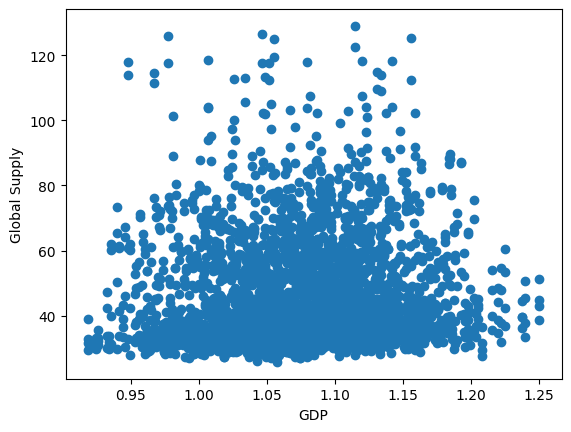

In [3]:
plt.scatter(Xy['GDP'], Xy['GSupply'])
plt.ylabel('Global Supply')
plt.xlabel('GDP')

In [4]:
Xy.columns.tolist()

['Scenario',
 'SOW',
 'Temp_Limit',
 'Delay',
 'GDP',
 'Pop',
 'Other_ESD_Drivers',
 'SDR',
 'Elast_ESD_Driver',
 'Elast_ESD_Price',
 'CO2_Storage_Poten',
 'Wind_Poten',
 'Solar_Poten',
 'Biomass_Poten',
 'Oil_Gas_Poten',
 'Solar_PV_Inv_Cost',
 'Wind_Inv_Cost',
 'Bioenergy_CCS_Inv_Cost',
 'Other_Tech_Cost',
 'Forcing',
 'Land_Sinks',
 'Clim_Sens',
 'Year',
 'Temp_Change',
 'Rad_Forcing',
 'CO2_Conc',
 'CH4_Conc',
 'N20_Conc',
 'Carbon',
 'CO2eq',
 'Marg_CO2_Cost',
 'GSupply',
 'GSupply_Bioenergy',
 'GSupply_Fossil',
 'GSupply_Geothermal',
 'GSupply_Nuclear',
 'GSupply_Solar',
 'GSupply_Tidal_Waves',
 'GSupply_Wind',
 'GConsumption',
 'GConsumption_Fossil',
 'GConsumption_Nuclear',
 'GConsumption_Renewable',
 'GCost']

<Axes: >

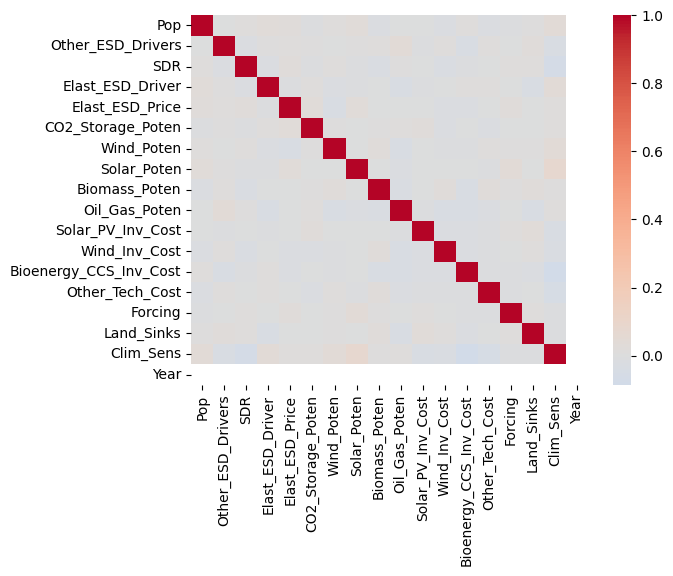

In [ ]:
features = [
 'Pop',
 'Other_ESD_Drivers',
 'SDR',
 'Elast_ESD_Driver',
 'Elast_ESD_Price',
 'CO2_Storage_Poten',
 'Wind_Poten',
 'Solar_Poten',
 'Biomass_Poten',
 'Oil_Gas_Poten',
 'Solar_PV_Inv_Cost',
 'Wind_Inv_Cost',
 'Bioenergy_CCS_Inv_Cost',
 'Other_Tech_Cost',
 'Forcing',
 'Land_Sinks',
 'Clim_Sens',
 'Year']


## Experimental Design

We try several target variables (ie dependent variable), several subsets of independent variables, several regression models. 

## Cross-validation

In preliminary experiments we see large differences in performance according to train-test split - therefore, we use a 5-fold cross-validation.

## Reporting

For each of those 5 folds, we report the train $R^2$ and test $R^2$.

In [6]:
# We have two sets of X-variable subsets: 'small' and 'all'
# For each subset, we have a variant which includes the scenario-encoding variables (_inc_enc)
# and a variant which excludes them.
# The idea is to compare a small versus a large subset for each scenario.
# And then as an alternative, put all the scenarios together, with the scenario-encoding
# variables included, and compare small versus large.
xvar_subsets = {
    'small': ['SDR', 'Clim_Sens', 'Pop', 'GDP'],
    'small_inc_enc': ['Temp_Limit', 'Delay', 'SDR', 'Clim_Sens', 'Pop', 'GDP'],
    'all': ['GDP', 'Pop',
       'Other_ESD_Drivers', 'SDR', 'Elast_ESD_Driver', 'Elast_ESD_Price',
       'CO2_Storage_Poten', 'Wind_Poten', 'Solar_Poten', 'Biomass_Poten',
       'Oil_Gas_Poten', 'Solar_PV_Inv_Cost', 'Wind_Inv_Cost',
       'Bioenergy_CCS_Inv_Cost', 'Other_Tech_Cost', 'Forcing', 'Land_Sinks',
       'Clim_Sens'],
    'all_inc_enc': ['Temp_Limit', 'Delay', 'GDP', 'Pop',
       'Other_ESD_Drivers', 'SDR', 'Elast_ESD_Driver', 'Elast_ESD_Price',
       'CO2_Storage_Poten', 'Wind_Poten', 'Solar_Poten', 'Biomass_Poten',
       'Oil_Gas_Poten', 'Solar_PV_Inv_Cost', 'Wind_Inv_Cost',
       'Bioenergy_CCS_Inv_Cost', 'Other_Tech_Cost', 'Forcing', 'Land_Sinks',
       'Clim_Sens']
}

scenarios = ['BASE_SSP2', '1p5c_OS_SSP2', '2C_SSP2', '2C_SSP2_DA30', 'ALL']

targets = ['GSupply', 'CO2eq', 'GConsumption', 'GCost'] # cannot do marginal CO2 as it's all-NaNs at 2050


print(type(xvar_subsets['small']))
print(xvar_subsets.keys())



<class 'list'>
dict_keys(['small', 'small_inc_enc', 'all', 'all_inc_enc'])


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import os
import matplotlib.pyplot as plt

def build_lstm_model(input_shape):                                                                      
    model = Sequential()                                                                                                        # Sequential model means that layers are stacked one after another in linear fashion, What are the other options? and what effect do they have?
    model.add(LSTM(50, activation='relu', input_shape=input_shape))                                                             # Here, we are adding an LSTM layer with 50 neurons, relu activation function (Tanh is more common), input_shape tells keras what to expect for each input sample.
    model.add(Dense(1))                                                                                                         # 'Dense' means it outputs a single value (regression)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')                                                              # This prepares the model for training. 'adam' is a popular optimizer that adapts learning rates during training
    return model                                                                                                                # learning rate is 0.001 which is a common starting point
                                                                                                                                # loss = 'mse' which is commonly used for regression problems
                                                                                                                                # returns the compiled model so it can be trained with .fit()

def run_everything(Xy):
    scenario = '2C_SSP2_DA30'
    target = 'GConsumption'
    Xy_sub = Xy[Xy['Scenario'] == scenario]

    for xvar_subset_code in xvar_subsets:
        if scenario == 'ALL' and (not "_inc_enc" in xvar_subset_code): continue
        if scenario != 'ALL' and ("_inc_enc" in xvar_subset_code): continue

        xvar_subset = xvar_subsets[xvar_subset_code]
        X = Xy_sub[xvar_subset]
        y = Xy_sub[target]

        print(f'Scenario {scenario}, xvar code {xvar_subset_code}, target {target}')

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                                                                                                                                 # the train and test splits are being reshaped into the format of (number of rows, 1, number of cols )
                                                                                                                                 # LSTM in keras expects input in the shape: (samples, timesteps, features)
        X_train_lstm = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))                                       # where 'samples' is the number of training samples, 'timestep' is how many timesteps per sample
        X_test_lstm = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))                                           # and 'features' is the number of features per timestep
        y_train_np = y_train.to_numpy()                                                                                          # all train and test splits are being reshaped to give a 3D input to LTSM

        # Build and train LSTM
        model = build_lstm_model((1, X_train.shape[1]))                                                                          # This looks like a 2D tuple, but its actually specifying the shape of each input sample, not the entire dataset
                                                                                                                                 # Keras infers batch size during training. 
        model.fit(X_train_lstm, y_train_np, epochs=50, verbose=0)                                                                # Model will go through the training data 50 times, updating its weights each time based on the error it observes
        y_pred = model.predict(X_test_lstm).flatten()                                                                            # Converts the output from 2D array to 1D array

        # SHAP explainer (using lambda to reshape input)
        explainer = shap.Explainer(lambda x: model.predict(x.reshape((x.shape[0], 1, x.shape[1]))).flatten(), X_train.to_numpy())
        shap_values = explainer(X_test.to_numpy())

        # Plotting
        model_name = 'LSTMRegressor'
        plots = ['bar', 'scatter', 'heatmap', 'beeswarm', 'violin', 'waterfall']
        for plot in plots:
            plt.figure(figsize=(10, 6))
            if plot == 'bar':
                shap.plots.bar(shap_values, max_display=10, show=False)
            elif plot == 'scatter':
                shap.plots.scatter(shap_values, show=False)
            elif plot == 'heatmap':
                shap.plots.heatmap(shap_values, show=False)
            elif plot == 'violin':
                shap.plots.violin(shap_values, show=False)
            elif plot == 'beeswarm':
                shap.plots.beeswarm(shap_values, show=False)
            elif plot == 'waterfall':
                shap.plots.waterfall(shap_values[0], max_display=10, show=False)

            fig = plt.gcf()
            fig.suptitle(f"{plot} plot for Scenario: {scenario}, Target: {target}, Subset: {xvar_subset_code}\nModel: {model_name}", fontsize=8, y=0.98)
            fig.subplots_adjust(top=0.85)

            output_dir = f"shap_outputs_08July2025/{model_name}/{scenario}/{target}/{xvar_subset_code}"
            os.makedirs(output_dir, exist_ok=True)
            file_path = f"{output_dir}/{plot}.pdf"
            fig.savefig(file_path, bbox_inches='tight')
            plt.show()
            plt.close(fig)

        print(f"Saved plot to: {os.path.abspath(file_path)}")

Scenario 2C_SSP2_DA30, xvar code small, target GConsumption


c:\Users\Sophie\OneDrive - National University of Ireland, Galway\Y1S2\Thesis\SHAP + RFR or PySR or NN\capstone2025-shiels-TIMES\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ExactExplainer explainer:   1%|          | 1/161 [00:00<?, ?it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   2%|▏         | 3/161 [00:12<00:27,  5.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   2%|▏         | 4/161 [00:13<00:38,  4.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   3%|▎         | 5/161 [00:13<00:52,  2.97it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▎         | 6/161 [00:13<00:52,  2.95it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   4%|▍         | 7/161 [00:14<00:52,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   5%|▍         | 8/161 [00:14<00:51,  2.99it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   6%|▌         | 9/161 [00:14<00:49,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 10/161 [00:15<00:49,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:   7%|▋         | 11/161 [00:15<00:55,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   7%|▋         | 12/161 [00:16<00:52,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 13/161 [00:16<00:49,  2.96it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   9%|▊         | 14/161 [00:16<00:47,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 15/161 [00:16<00:46,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|▉         | 16/161 [00:17<00:44,  3.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 17/161 [00:17<00:45,  3.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  11%|█         | 18/161 [00:17<00:43,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 19/161 [00:18<00:42,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  12%|█▏        | 20/161 [00:18<00:41,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  13%|█▎        | 21/161 [00:18<00:40,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  14%|█▎        | 22/161 [00:18<00:40,  3.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 23/161 [00:19<00:39,  3.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  15%|█▍        | 24/161 [00:19<00:41,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 25/161 [00:19<00:40,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 26/161 [00:20<00:39,  3.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 27/161 [00:20<00:38,  3.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 28/161 [00:20<00:38,  3.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  18%|█▊        | 29/161 [00:20<00:37,  3.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  19%|█▊        | 30/161 [00:21<00:39,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 31/161 [00:21<00:38,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|█▉        | 32/161 [00:21<00:37,  3.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 33/161 [00:22<00:37,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  21%|██        | 34/161 [00:22<00:36,  3.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 35/161 [00:22<00:36,  3.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 36/161 [00:23<00:35,  3.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 37/161 [00:23<00:37,  3.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▎       | 38/161 [00:23<00:36,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 39/161 [00:23<00:35,  3.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▍       | 40/161 [00:24<00:35,  3.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 41/161 [00:24<00:34,  3.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 42/161 [00:24<00:33,  3.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 43/161 [00:25<00:35,  3.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 44/161 [00:25<00:37,  3.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 45/161 [00:25<00:38,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▊       | 46/161 [00:26<00:39,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  29%|██▉       | 47/161 [00:26<00:40,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  30%|██▉       | 48/161 [00:26<00:40,  2.81it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  30%|███       | 49/161 [00:27<00:42,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  31%|███       | 50/161 [00:27<00:41,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 51/161 [00:28<00:40,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  32%|███▏      | 52/161 [00:28<00:40,  2.71it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 53/161 [00:28<00:39,  2.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▎      | 54/161 [00:29<00:39,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 55/161 [00:29<00:40,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▍      | 56/161 [00:29<00:39,  2.64it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 57/161 [00:30<00:39,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 58/161 [00:30<00:38,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 59/161 [00:31<00:37,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  37%|███▋      | 60/161 [00:31<00:36,  2.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  38%|███▊      | 61/161 [00:31<00:38,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▊      | 62/161 [00:32<00:38,  2.59it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  39%|███▉      | 63/161 [00:32<00:37,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|███▉      | 64/161 [00:32<00:37,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  40%|████      | 65/161 [00:33<00:36,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  41%|████      | 66/161 [00:33<00:35,  2.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  42%|████▏     | 67/161 [00:34<00:36,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  42%|████▏     | 68/161 [00:34<00:36,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  43%|████▎     | 69/161 [00:34<00:35,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  43%|████▎     | 70/161 [00:35<00:34,  2.65it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  44%|████▍     | 71/161 [00:35<00:33,  2.70it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▍     | 72/161 [00:36<00:34,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 73/161 [00:36<00:36,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  46%|████▌     | 74/161 [00:36<00:35,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 75/161 [00:37<00:35,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  47%|████▋     | 76/161 [00:37<00:33,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  48%|████▊     | 77/161 [00:38<00:32,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  48%|████▊     | 78/161 [00:38<00:31,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  49%|████▉     | 79/161 [00:38<00:33,  2.48it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  50%|████▉     | 80/161 [00:39<00:31,  2.57it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  50%|█████     | 81/161 [00:39<00:29,  2.73it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  51%|█████     | 82/161 [00:39<00:27,  2.86it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 83/161 [00:40<00:25,  3.01it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  52%|█████▏    | 84/161 [00:40<00:24,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 85/161 [00:40<00:25,  2.98it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 86/161 [00:41<00:24,  3.08it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  54%|█████▍    | 87/161 [00:41<00:23,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▍    | 88/161 [00:41<00:22,  3.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  55%|█████▌    | 89/161 [00:42<00:22,  3.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  56%|█████▌    | 90/161 [00:42<00:21,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  57%|█████▋    | 91/161 [00:42<00:22,  3.07it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  57%|█████▋    | 92/161 [00:43<00:23,  2.92it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  58%|█████▊    | 93/161 [00:43<00:28,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  58%|█████▊    | 94/161 [00:44<00:29,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  59%|█████▉    | 95/161 [00:44<00:29,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|█████▉    | 96/161 [00:45<00:29,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  60%|██████    | 97/161 [00:45<00:29,  2.17it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  61%|██████    | 98/161 [00:46<00:28,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  61%|██████▏   | 99/161 [00:46<00:27,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  62%|██████▏   | 100/161 [00:46<00:27,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  63%|██████▎   | 101/161 [00:47<00:26,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  63%|██████▎   | 102/161 [00:47<00:26,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  64%|██████▍   | 103/161 [00:48<00:26,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▍   | 104/161 [00:48<00:25,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  65%|██████▌   | 105/161 [00:49<00:24,  2.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  66%|██████▌   | 106/161 [00:49<00:24,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  66%|██████▋   | 107/161 [00:50<00:23,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 108/161 [00:50<00:23,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 109/161 [00:50<00:23,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 110/161 [00:51<00:22,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  69%|██████▉   | 111/161 [00:51<00:21,  2.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  70%|██████▉   | 112/161 [00:52<00:21,  2.28it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  70%|███████   | 113/161 [00:52<00:21,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████   | 114/161 [00:53<00:21,  2.20it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  71%|███████▏  | 115/161 [00:53<00:20,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  72%|███████▏  | 116/161 [00:54<00:20,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  73%|███████▎  | 117/161 [00:54<00:19,  2.23it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  73%|███████▎  | 118/161 [00:54<00:19,  2.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  74%|███████▍  | 119/161 [00:55<00:19,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▍  | 120/161 [00:55<00:19,  2.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  75%|███████▌  | 121/161 [00:56<00:18,  2.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 122/161 [00:56<00:17,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  76%|███████▋  | 123/161 [00:57<00:17,  2.21it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  77%|███████▋  | 124/161 [00:57<00:16,  2.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  78%|███████▊  | 125/161 [00:58<00:16,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  78%|███████▊  | 126/161 [00:58<00:16,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  79%|███████▉  | 127/161 [00:59<00:15,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|███████▉  | 128/161 [00:59<00:15,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  80%|████████  | 129/161 [01:00<00:14,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  81%|████████  | 130/161 [01:00<00:14,  2.16it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  81%|████████▏ | 131/161 [01:00<00:13,  2.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  82%|████████▏ | 132/161 [01:01<00:12,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  83%|████████▎ | 133/161 [01:01<00:12,  2.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  83%|████████▎ | 134/161 [01:02<00:11,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 135/161 [01:02<00:10,  2.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  84%|████████▍ | 136/161 [01:03<00:10,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  85%|████████▌ | 137/161 [01:03<00:10,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 138/161 [01:03<00:09,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  86%|████████▋ | 139/161 [01:04<00:09,  2.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  87%|████████▋ | 140/161 [01:04<00:08,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  88%|████████▊ | 141/161 [01:05<00:08,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  88%|████████▊ | 142/161 [01:05<00:07,  2.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  89%|████████▉ | 143/161 [01:05<00:07,  2.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  89%|████████▉ | 144/161 [01:06<00:06,  2.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  90%|█████████ | 145/161 [01:06<00:06,  2.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  91%|█████████ | 146/161 [01:07<00:06,  2.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  91%|█████████▏| 147/161 [01:07<00:05,  2.36it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  92%|█████████▏| 148/161 [01:07<00:05,  2.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  93%|█████████▎| 149/161 [01:08<00:04,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  93%|█████████▎| 150/161 [01:08<00:04,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  94%|█████████▍| 151/161 [01:09<00:04,  2.47it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  94%|█████████▍| 152/161 [01:09<00:03,  2.56it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 153/161 [01:09<00:03,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▌| 154/161 [01:10<00:02,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  96%|█████████▋| 155/161 [01:10<00:02,  2.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  97%|█████████▋| 156/161 [01:11<00:01,  2.63it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 157/161 [01:11<00:01,  2.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  98%|█████████▊| 158/161 [01:11<00:01,  2.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▉| 159/161 [01:12<00:00,  2.31it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


ExactExplainer explainer:  99%|█████████▉| 160/161 [01:12<00:00,  2.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer: 100%|██████████| 161/161 [01:13<00:00,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer: 162it [01:13,  2.18it/s]                         


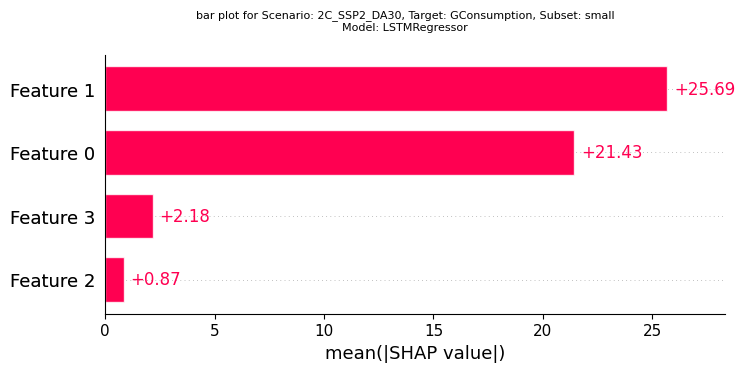

<Figure size 1000x600 with 0 Axes>

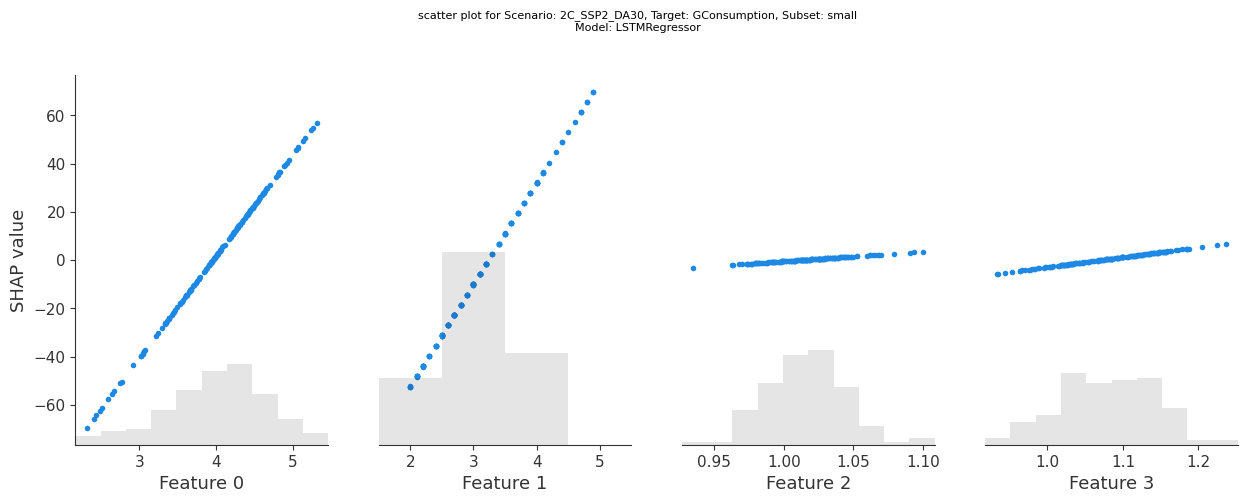

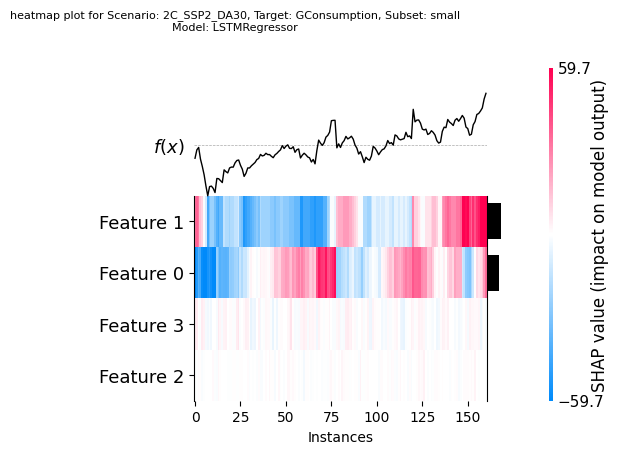

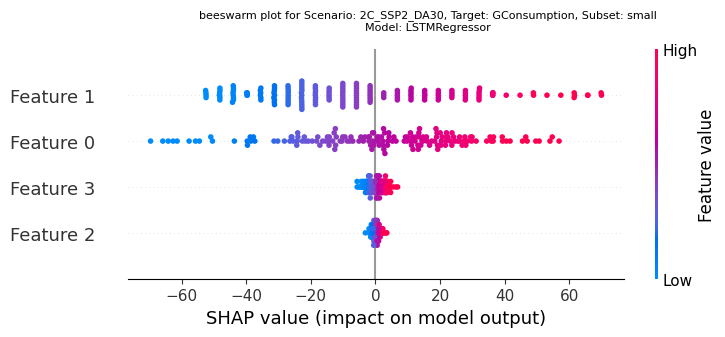

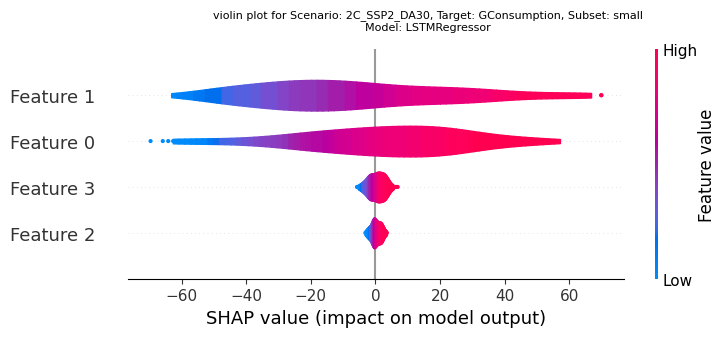

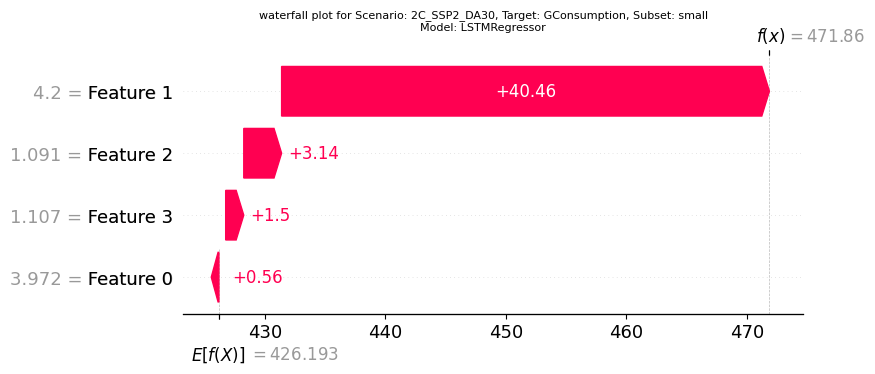

Saved plot to: c:\Users\Sophie\OneDrive - National University of Ireland, Galway\Y1S2\Thesis\SHAP + RFR or PySR or NN\capstone2025-shiels-TIMES\shap_outputs_08July2025\LSTMRegressor\2C_SSP2_DA30\GConsumption\small\waterfall.pdf
Scenario 2C_SSP2_DA30, xvar code all, target GConsumption


c:\Users\Sophie\OneDrive - National University of Ireland, Galway\Y1S2\Thesis\SHAP + RFR or PySR or NN\capstone2025-shiels-TIMES\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━

PermutationExplainer explainer:   1%|          | 2/161 [00:00<?, ?it/s]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   2%|▏         | 4/161 [00:19<08:50,  3.38s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   3%|▎         | 5/161 [00:25<12:17,  4.73s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 6/161 [00:32<14:07,  5.47s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   4%|▍         | 7/161 [00:39<15:21,  5.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   5%|▍         | 8/161 [00:46<16:02,  6.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 9/161 [00:53<16:18,  6.44s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 10/161 [00:59<15:54,  6.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   7%|▋         | 11/161 [01:06<16:18,  6.52s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 12/161 [01:12<16:17,  6.56s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 13/161 [01:19<16:12,  6.57s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▊         | 14/161 [01:26<16:09,  6.60s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 15/161 [01:31<15:00,  6.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|▉         | 16/161 [01:36<13:56,  5.77s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 17/161 [01:41<13:20,  5.56s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 18/161 [01:46<13:01,  5.47s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 19/161 [01:51<12:42,  5.37s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 20/161 [01:56<12:24,  5.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  13%|█▎        | 21/161 [02:01<12:23,  5.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  14%|█▎        | 22/161 [02:10<14:43,  6.35s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 23/161 [02:18<15:45,  6.85s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▍        | 24/161 [02:27<16:42,  7.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 25/161 [02:33<15:45,  6.95s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  16%|█▌        | 26/161 [02:39<15:02,  6.69s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  17%|█▋        | 27/161 [02:45<14:49,  6.64s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 28/161 [02:51<14:20,  6.47s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 29/161 [02:57<13:55,  6.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▊        | 30/161 [03:04<13:47,  6.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 31/161 [03:10<13:49,  6.38s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|█▉        | 32/161 [03:16<13:22,  6.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 33/161 [03:22<13:17,  6.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 34/161 [03:29<13:28,  6.37s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 35/161 [03:35<13:14,  6.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 36/161 [03:41<12:56,  6.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  23%|██▎       | 37/161 [03:50<14:17,  6.91s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▎       | 38/161 [04:00<16:26,  8.02s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 39/161 [04:06<14:59,  7.37s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  25%|██▍       | 40/161 [04:12<13:57,  6.92s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 41/161 [04:20<14:11,  7.09s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  26%|██▌       | 42/161 [04:30<16:19,  8.23s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 43/161 [04:38<15:33,  7.91s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 44/161 [04:44<14:27,  7.41s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 45/161 [04:50<13:31,  7.00s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▊       | 46/161 [04:56<12:43,  6.64s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 47/161 [05:02<12:09,  6.40s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  30%|██▉       | 48/161 [05:07<11:46,  6.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 49/161 [05:13<11:33,  6.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 50/161 [05:20<11:49,  6.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 51/161 [05:27<11:37,  6.34s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 52/161 [05:33<11:25,  6.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 53/161 [05:39<11:09,  6.20s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▎      | 54/161 [05:45<11:08,  6.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 55/161 [05:51<10:56,  6.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▍      | 56/161 [05:57<10:43,  6.13s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 57/161 [06:02<10:02,  5.79s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 58/161 [06:08<09:46,  5.69s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 59/161 [06:13<09:28,  5.57s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 60/161 [06:17<08:52,  5.27s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 61/161 [06:23<09:09,  5.49s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▊      | 62/161 [06:29<09:18,  5.64s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  39%|███▉      | 63/161 [06:36<09:29,  5.81s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 64/161 [06:40<08:43,  5.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 65/161 [06:45<08:11,  5.12s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 66/161 [06:49<07:48,  4.93s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 67/161 [06:53<07:22,  4.70s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 68/161 [06:57<06:53,  4.45s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 69/161 [07:01<06:22,  4.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 70/161 [07:04<06:02,  3.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  44%|████▍     | 71/161 [07:08<05:50,  3.89s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▍     | 72/161 [07:11<05:36,  3.78s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  45%|████▌     | 73/161 [07:15<05:22,  3.67s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  46%|████▌     | 74/161 [07:19<05:26,  3.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 75/161 [07:22<05:22,  3.76s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 76/161 [07:27<05:44,  4.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 77/161 [07:32<05:48,  4.15s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 78/161 [07:36<05:49,  4.21s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  49%|████▉     | 79/161 [07:40<05:48,  4.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|████▉     | 80/161 [07:45<05:47,  4.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 81/161 [07:49<05:40,  4.26s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████     | 82/161 [07:53<05:38,  4.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 83/161 [07:57<05:35,  4.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 84/161 [08:02<05:29,  4.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 85/161 [08:06<05:26,  4.30s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 86/161 [08:10<05:23,  4.32s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  54%|█████▍    | 87/161 [08:14<05:03,  4.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  55%|█████▍    | 88/161 [08:18<04:48,  3.95s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  55%|█████▌    | 89/161 [08:21<04:38,  3.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  56%|█████▌    | 90/161 [08:25<04:31,  3.82s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  57%|█████▋    | 91/161 [08:29<04:22,  3.75s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  57%|█████▋    | 92/161 [08:32<04:19,  3.76s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 93/161 [08:36<04:12,  3.71s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  58%|█████▊    | 94/161 [08:40<04:10,  3.74s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▉    | 95/161 [08:43<04:05,  3.72s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|█████▉    | 96/161 [08:47<04:00,  3.70s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|██████    | 97/161 [08:51<04:01,  3.78s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 98/161 [08:55<03:57,  3.77s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  61%|██████▏   | 99/161 [08:59<03:53,  3.77s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  62%|██████▏   | 100/161 [09:02<03:40,  3.62s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  63%|██████▎   | 101/161 [09:05<03:31,  3.53s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


PermutationExplainer explainer:  63%|██████▎   | 102/161 [09:08<03:22,  3.43s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|██████▍   | 103/161 [09:12<03:14,  3.35s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  65%|██████▍   | 104/161 [09:15<03:11,  3.35s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  65%|██████▌   | 105/161 [09:18<03:05,  3.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|██████▌   | 106/161 [09:21<03:03,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  66%|██████▋   | 107/161 [09:25<02:57,  3.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  67%|██████▋   | 108/161 [09:28<02:56,  3.33s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  68%|██████▊   | 109/161 [09:32<02:54,  3.35s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  68%|██████▊   | 110/161 [09:35<02:52,  3.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  69%|██████▉   | 111/161 [09:38<02:49,  3.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  70%|██████▉   | 112/161 [09:42<02:46,  3.40s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  70%|███████   | 113/161 [09:45<02:45,  3.46s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 114/161 [09:49<02:41,  3.45s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  71%|███████▏  | 115/161 [09:53<02:46,  3.62s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 116/161 [09:57<02:54,  3.87s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  73%|███████▎  | 117/161 [10:01<02:49,  3.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  73%|███████▎  | 118/161 [10:05<02:39,  3.72s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  74%|███████▍  | 119/161 [10:08<02:30,  3.59s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  75%|███████▍  | 120/161 [10:12<02:32,  3.71s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  75%|███████▌  | 121/161 [10:17<02:51,  4.28s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 122/161 [10:24<03:18,  5.10s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  76%|███████▋  | 123/161 [10:31<03:29,  5.52s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 124/161 [10:37<03:28,  5.64s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 125/161 [10:42<03:21,  5.59s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 126/161 [10:48<03:17,  5.63s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  79%|███████▉  | 127/161 [10:54<03:13,  5.68s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|███████▉  | 128/161 [10:59<03:06,  5.65s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 129/161 [11:04<02:53,  5.42s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 130/161 [11:09<02:43,  5.29s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████▏ | 131/161 [11:14<02:37,  5.25s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 132/161 [11:19<02:26,  5.05s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 133/161 [11:23<02:14,  4.80s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 134/161 [11:28<02:11,  4.86s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 135/161 [11:35<02:20,  5.40s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 136/161 [11:41<02:23,  5.73s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▌ | 137/161 [11:48<02:22,  5.95s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 138/161 [11:53<02:11,  5.73s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▋ | 139/161 [11:58<02:01,  5.54s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  87%|████████▋ | 140/161 [12:05<02:05,  5.97s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 141/161 [12:12<02:04,  6.22s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 142/161 [12:19<02:00,  6.34s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 143/161 [12:25<01:53,  6.31s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 144/161 [12:31<01:45,  6.19s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  90%|█████████ | 145/161 [12:38<01:42,  6.39s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  91%|█████████ | 146/161 [12:45<01:42,  6.84s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████▏| 147/161 [12:52<01:35,  6.84s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 148/161 [12:59<01:28,  6.78s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  93%|█████████▎| 149/161 [13:05<01:17,  6.49s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 150/161 [13:09<01:04,  5.89s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 151/161 [13:14<00:55,  5.51s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  94%|█████████▍| 152/161 [13:19<00:48,  5.42s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  95%|█████████▌| 153/161 [13:25<00:45,  5.72s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▌| 154/161 [13:33<00:43,  6.16s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▋| 155/161 [13:39<00:36,  6.07s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 156/161 [13:44<00:29,  5.99s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 157/161 [13:50<00:23,  5.98s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 158/161 [13:57<00:18,  6.11s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  99%|█████████▉| 159/161 [14:03<00:12,  6.17s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 160/161 [14:11<00:06,  6.70s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 100%|██████████| 161/161 [14:17<00:00,  6.64s/it]

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 162it [14:23,  5.40s/it]                         


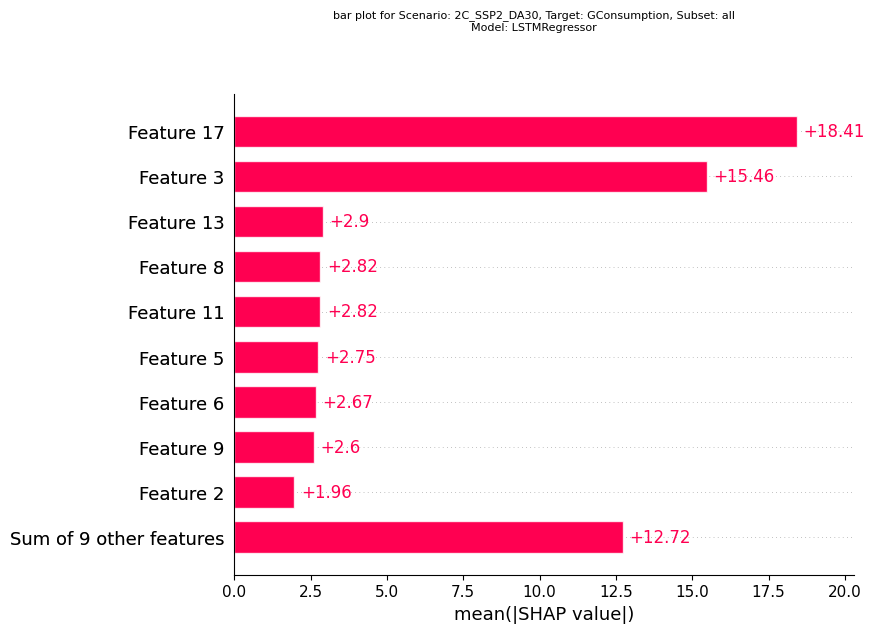

<Figure size 1000x600 with 0 Axes>

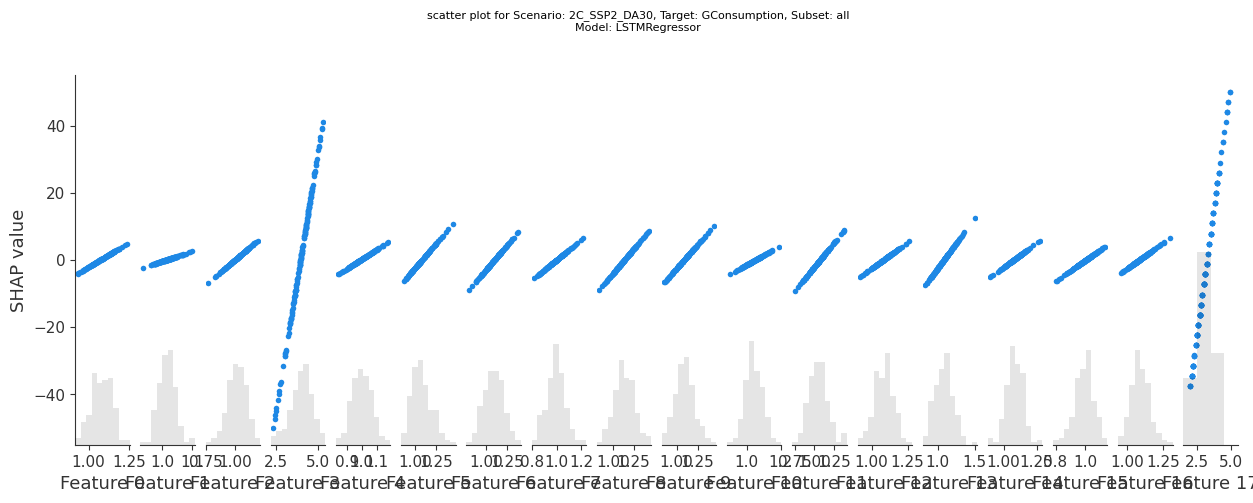

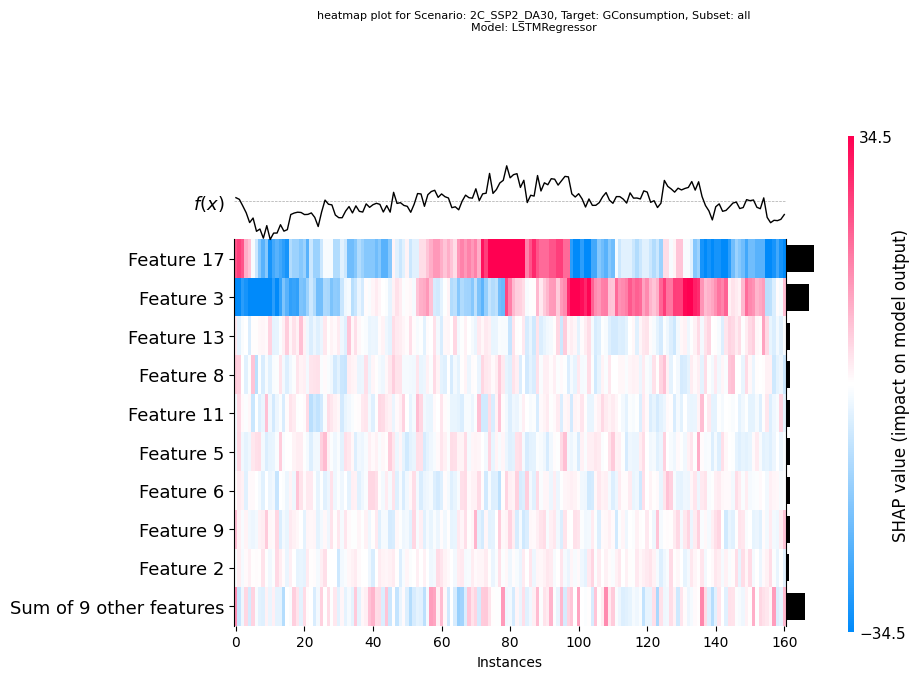

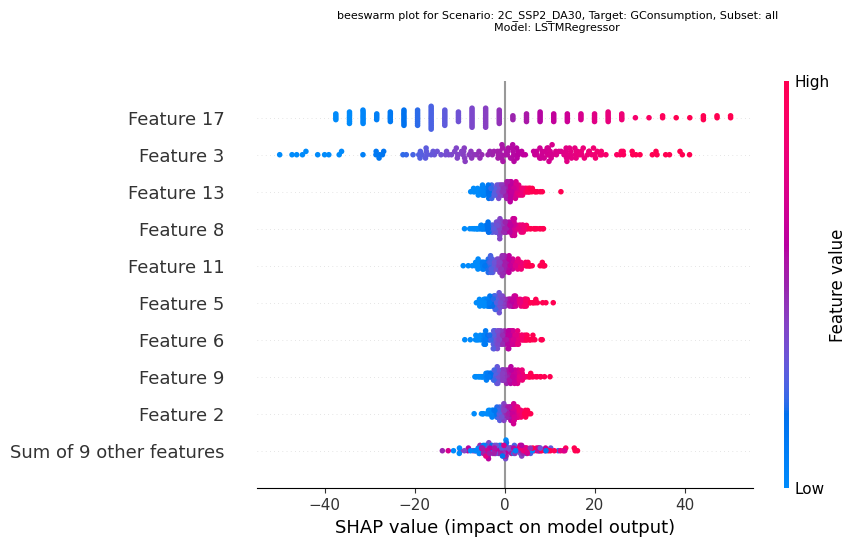

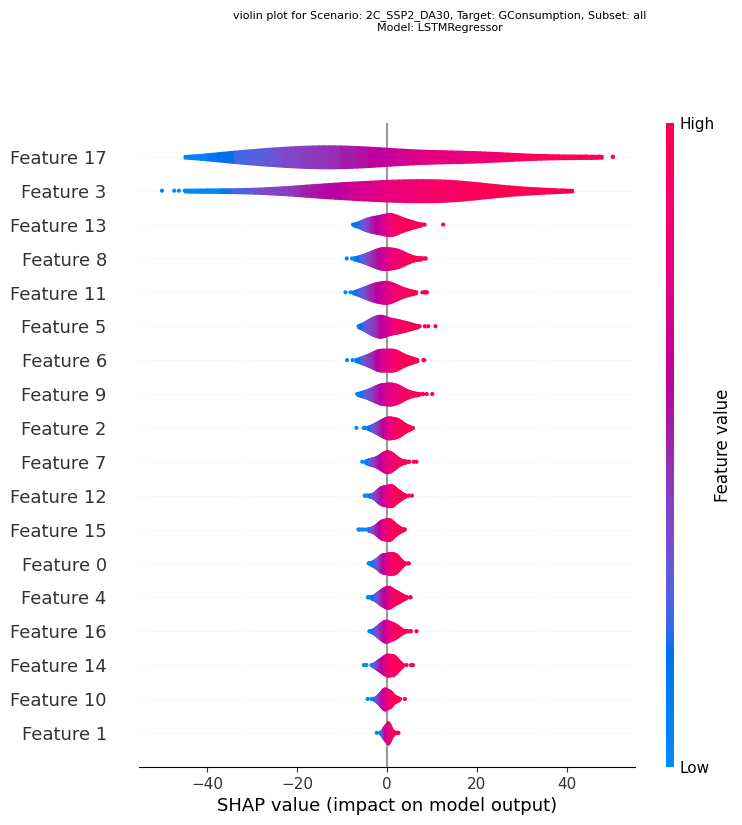

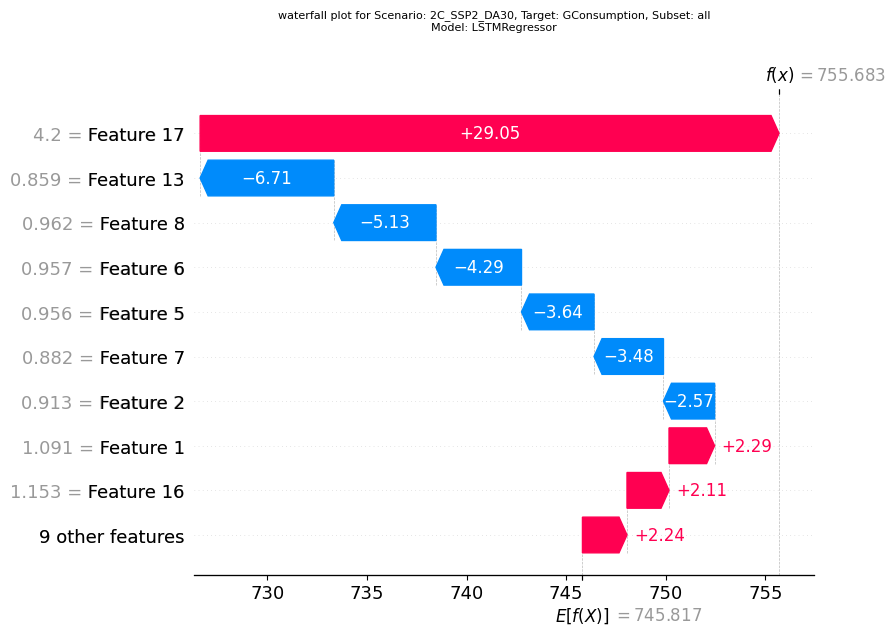

2025-08-11 20:28:51.021298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Saved plot to: c:\Users\Sophie\OneDrive - National University of Ireland, Galway\Y1S2\Thesis\SHAP + RFR or PySR or NN\capstone2025-shiels-TIMES\shap_outputs_08July2025\LSTMRegressor\2C_SSP2_DA30\GConsumption\all\waterfall.pdf


In [8]:
run_everything(Xy)  

# Bar Plots
The bar plot shows which features are most important to the model. It plots the absolute mean shap plot. each bar gives the absolute mean shap value of each feature. There is a shap value for each instance of each feature. The absolute value is taken and the mean is calculated. We take the absolute value as we do not want positive and negative values to offset eachother.
Values that have made large positive or negative contributions will have a large shap value. These are the features that have made a significant contribution to the models predictions. This is a useful measure of feature importance. 


# Beeswarm plot
This helps to visualise all shap values. On the Y-axis the values are grouped by all the features.The colour of the points is determined by the feature value. Higher values are red. On the X axis is the shap values. This can help to highlight important relationships. It shows which values have large positive or large negative values. The beeswarm plot can help understand the nature of relationships between feature variables - for example, in our beeswarm plot, for almost all variables, as the feature value increases, so does the shap values (except for wind_inv_cost)

# Dependence plots 
Not completed yet

# Violin Plot
Gives the same insights as the beeswarm plot

# Heatmap
X-axis shows a tick for each instance of data
Y-axis gives the model feature
The line above each instance is coloured by the shap value for that feature. 
The f(x) line (the line at the top of the graph) gives the predicted y value for that instance. 
The faint grey line behind the f(x) plot is the baseline or expected value of the models predictions
The bar on the right gives the mean shap values (these are the same as what we saw in the bar plot). 
The heatmap is a plot of every shap value, except we focus on shap values and groups of instances. 
By default the instances are ordered using a hierarchical clustering algorithm. optionally: We can change it to be ordered by the values of one of the features

## Interpreting plots
Scenario: BASE_SSP2
    - This scenario means that there is no upper limit on temperature increase . There is also no delay as there is no action
Target: GSupply
Subset: All
# Heatmap
This plot only shows 161 instances
'Elast_ESD_Driver' is given as the most influential feature in predicting GSupply. It seems to have both a strong positive and negative influence on the target variable

# Violin plot
Again, 'Elast_ESD_Driver' is the most influential in predicting 'GSupply' in both a positive and negative direction. Lower feature values correlate with lower 'Elast_ESD_Driver' values. The same can be said for 'GDP' and 'Other_ESD_Drivers'. 

# Scatter plot
This is a dependence scatter plot. it shows the effect that a single feature has on the prediction. Each dot is a single prediction of GSupply. The X-axis is the value of the feature. 
The Y-axis is the shap value of the feature. This represents how much knowing that features value changes the output of the model for that samples prediction
The light grey area in the background is a histogram showing the distribution of the data values. 
The histogram plots how many times a certain value appears for a feature in the dataset

We can see that with an increase in SHAP values for GDP, Other_ESD_Drivers and Elast_ESD_Driver, there is an increase in GSupply. There is also a slightly negative trend in shap values for Oil_Gas_Poten and Wind_Inv_Cost as GSupply increases

# Bar Plot
The bar plot shows a similar story



# Interpreting plots:
Scenario: 2C_SSP2_DA30
    This scenario means that there is a 2 degree celcius limit on temperature increase, with a 25 year delay action
Target: GSupply
Subset: All

# Heatmap
Clim_Sens is the most impactful feature on the model. Increase in Clim_Sens is associated with increase in GSupply.
# Violin plot and beeswarm
The more negative the shap value for Clim_sens leads to a more negative feature value.
There is a larger number of Shap values in the negative range for Clim_Sens than in the positive range. 
The more positive the Shap value for SDR, the more negative the feature value
# Bar Plot
Shows that Clim_Sens has the greatest mean absolute shap value, followed by Elast_ESD_Driver, SRD and GDP
# Scatter plot
This shows that as the value of GDP, Elast_ESD_Driver and Clim_Sens increases, so does the SHAP value. And as SDR increases, the shap values decrease




# Interpreting plots:
Scenario: 2C_SSP2_DA30
    This scenario means that there is a 2 degree celcius limit on temperature increase, with a 25 year delay action
Target: GConsumption
Subset: All

# Heatmap
Both Clim_Sens and Elast_ESD_Driver are closely tied as being most impactful to the prediction of GConsumption for the 2C_SSP2_DA30 scenario. There is no general pattern for 
# Violin plot and beeswarm
# Bar Plot
# Scatter plot

# The Background data:
The key behind shapley values is that the features act as a "team", and the prediction is fairly distributed among them. The algorithm computes what predictions different coalitions (subsets of features) would receive. Since most ML models require all data to be filled in, missing values are sampled from the background data. Different background datasets can make different shap interpretations. What ever we choose as the background dataset influences for which data points we get predictions, and therefore what the interpretation is. for example, if we choose the background data based on a certain feature, this feature will no longer explain variation. Analogy: Height is an influential factor on performance in playing basketball. But within the NBA, where most players are tall, height no longer explains differences in performance. This is similar to collider bias or selection bias. Whether it is a problem or not depends on the purpose of the analysis - the example given for this is when comparing a wine against only high alcohol wines.

# shap.Explainer:
- Uses Shapley values to explain any ML model or python function.
- It is the primary explainer interface for the SHAP library. It takes any combo of model and masker and returns a callable subclass object that implements the particular estimation algorithm that was chosen.
    - Masker: explainer takes 'masker' as a parameter. The function is used to 'mask' out hidden features of the form masked_args = masker(*model_args, mask=mask). Background data matrices can be passed instead of a function, and the matrix will be used for masking. This is a shortcut for standard masking.

# Kernel Explainer:
Kernel SHAP is a model agnostic explainer. It is a method that uses special weighted linear regression to compute the importance of each feature. The computed importance values are Shapley values adn also coefficients from a local linear regression.



In [9]:
cv = 5
#results = run_everything(Xy, cv)
results_cols = ['Target', 'Scenario', 'xvar_subset_code', 'Regression Model', 'Fold', 'Train Score', 'Test Score']
results_df = pd.DataFrame(results, columns=results_cols)
results_df['Scenario / Variables'] = results_df['Scenario'] + ' / ' + results_df['xvar_subset_code']
#results_df.to_csv(f'../outputs/results_cv5_EN_RF_2xGP_clim_sens_filter_sqrt.csv')

NameError: name 'results' is not defined

Check that the results are the shape we expect:

In [ ]:
results_df.head()

In [ ]:
results_df.shape

In [ ]:
5 * 4 * 2 * 4 * 5 # 5 scenarios (incl ALL), 4 targets, 2 xvar subsets (variant in the case of ALL), 4 regression methods, 5 cv folds

# Statistics

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
models = ['ElasticNet', 'RandomForestRegressor', 'PySRRegressor']
for model in models:
    sub = results_df[(results_df['Regression Model'] == model) & (results_df['Scenario'] != 'ALL')]['Test Score']
    print(f'{model} mean {sub.mean():.2f} std {sub.std():.1f}')
    for model2 in models:
        if model2 != model:
            sub2 = results_df[(results_df['Regression Model'] == model2) & (results_df['Scenario'] != 'ALL')]['Test Score']
            print(f'{model} {model2} {ttest_ind(sub, sub2)}')

In [ ]:
for model in models:
    sub1 = results_df[(results_df['Regression Model'] == model) & (results_df['xvar_subset_code'] == 'small')]['Test Score']
    sub2 = results_df[(results_df['Regression Model'] == model) & (results_df['xvar_subset_code'] == 'all')]['Test Score']
    print(f'{model} small {sub1.mean():.2f} v all {sub2.mean():.2f}: {ttest_ind(sub1, sub2)}')

In [ ]:
# plot the individual scenario regression results
for target in targets:

    # we exclude GPAFSRegressor for now
    tmp = results_df[(results_df['Target'] == target) & (results_df['Regression Model'] != 'GPAFSRegressor') 
                     & (results_df['Scenario'] != 'ALL')]

    sns.stripplot(tmp, x='Scenario / Variables', y='Train Score', hue='Regression Model');
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Train $R^2$ on {target}')
    plt.tight_layout()
    plt.savefig(f'../outputs/results_boxplot_cv5_{target}_train_clim_sens_filter_sqrt.pdf')
    plt.close()

    sns.stripplot(tmp, x='Scenario / Variables', y='Test Score', hue='Regression Model');
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Test $R^2$ on {target}')
    plt.tight_layout()
    plt.savefig(f'../outputs/results_boxplot_cv5_{target}_test_clim_sens_filter_sqrt.pdf')
    plt.close()


In [ ]:
# plot the *unified* scenario regression results
for target in targets:

    # we exclude GPAFSRegressor for now
    tmp = results_df[(results_df['Target'] == target) & (results_df['Regression Model'] != 'GPAFSRegressor')
                     & (results_df['Scenario'] == 'ALL')]

    sns.stripplot(tmp, x='Scenario / Variables', y='Train Score', hue='Regression Model');
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Train $R^2$ on {target}')
    plt.tight_layout()
    plt.savefig(f'../outputs/results_boxplot_cv5_{target}_unified_scenarios_train_clim_sens_filter_sqrt.pdf')
    plt.close()

    sns.stripplot(tmp, x='Scenario / Variables', y='Test Score', hue='Regression Model');
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Test $R^2$ on {target}')
    plt.tight_layout()
    plt.savefig(f'../outputs/results_boxplot_cv5_{target}_unified_scenarios_test_clim_sens_filter_sqrt.pdf')
    plt.close()


# Interpretation of models

## Variable importance and equation interpretation

In this section, we'll use a single train-test split and do a single run (per scenerio) for each of EN, RF, and SR
as our goal will not be a comparison of performance but an investigation of variable importance.

We include each scenario and all variables, not including the scenario-encoding variables.

RF gives variable importance directly.

EN does not, but we use abs(coefficient_i) * std(x_i)

SR we'll just store the equations together with their loss and complexity values.

In [ ]:
scenarios = ['BASE_SSP2', '1p5c_OS_SSP2', '2C_SSP2', '2C_SSP2_DA30']

import sympy_latex

for scenario in scenarios:
    Xy_tmp = Xy[Xy['Scenario'] == scenario]
    X = Xy_tmp[xvar_subsets['all']]
    for target in targets:
        y = Xy_tmp[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        for m in [#RandomForestRegressor(), 
                  #ElasticNet(), 
                  PySRRegressor(unary_operators=["sqrt"]), 
                  #GPAFSRegressor(20000, 4000, 0.5, 30, 5, "symbolic_regression.bnf", 0.3)]:
        ]:

            #m.fit(X_train, y_train)
            #m.score(X_test, y_test)

            if m.__class__.__name__ == 'RandomForestRegressor':
                # importance is given directly by the method
                imps = list(zip(m.feature_names_in_, m.feature_importances_))
                imps.sort(key=lambda x: x[1], reverse=True)
                imps = pd.DataFrame(imps, columns=['Feature', 'Importance'])
                # print, write importances to csv and to tex
                print(imps)
                imps.to_csv(f'../outputs/importances_rf_{scenario}_{target}_clim_sens_filter_sqrt.csv')
                imps['Feature'] = imps['Feature'].str.replace('_', ' ')
                imps.to_latex(f'../outputs/importances_rf_{scenario}_{target}_clim_sens_filter_sqrt.tex', index=False)     
            elif m.__class__.__name__ == 'ElasticNet':
                # importance is abs(coef) * std deviation of the var
                X_std = X_train.std(axis=0)
                imps = np.abs(m.coef_) * X_std
                imps = list(zip(m.feature_names_in_, imps))
                imps.sort(key=lambda x: x[1], reverse=True)
                imps = pd.DataFrame(imps, columns=['Feature', 'Importance'])
                # print, write importances to csv and to tex
                print(imps)
                imps.to_csv(f'../outputs/importances_en_{scenario}_{target}_clim_sens_filter_sqrt.csv')
                imps['Feature'] = imps['Feature'].str.replace('_', ' ')
                imps.to_latex(f'../outputs/importances_en_{scenario}_{target}_clim_sens_filter_sqrt.tex', index=False)
            elif m.__class__.__name__ == 'PySRRegressor' or m.__class__.__name__ == 'GPAFSRegressor':

                if m.__class__.__name__ == 'PySRRegressor': method = 'sr'
                if m.__class__.__name__ == 'GPAFSRegressor': method = 'magpie'

                # print, write original equations to csv
                #print(m.equations_)
                #m.equations_.to_csv(f'../outputs/equations_{method}_{scenario}_{target}_clim_sens_filter_sqrt.csv')
                # eqns = m.equations_

                eqns = pd.read_csv(f'../outputs/equations_{method}_{scenario}_{target}_clim_sens_filter_sqrt.csv')

                # write to latex table, but process first, and only useful columns
                eqns = sympy_latex.process_equations_latex(eqns)
                eqns = eqns[['vars', 'consts', 'complexity', 'loss', 'equation']]
                #eqns['equation'] = eqns['equation'].str.replace('_', ' ')
                eqns.to_latex(f'../outputs/equations_{method}_{scenario}_{target}_3cols_clim_sens_filter_sqrt.tex', index=False)
